In [1]:
import io

import geopandas as gpd
import ipywidgets as widgets
import numpy as np
import pandas as pd
import requests
from ipywidgets import FloatRangeSlider, jsdlink
from lonboard import Map, PolygonLayer
from lonboard.colormap import apply_continuous_cmap
from lonboard.layer_extension import DataFilterExtension
from matplotlib import colormaps
from matplotlib.colors import LogNorm


# English Indices of Multiple Deprivation

Quick example using [IMD 2019](https://assets.publishing.service.gov.uk/media/5d8b364ced915d03709e3cf2/IoD2019_Research_Report.pdf).

Download Lower Super Output Area statistical boundaries from ONS [here](https://geoportal.statistics.gov.uk/datasets/ons::lower-layer-super-output-areas-december-2011-boundaries-ew-bfc-v3/about). 

This is the 20m generalised version, ~50Mb.

Sadly the [GeoJSON API](https://services1.arcgis.com/ESMARspQHYMw9BZ9/arcgis/rest/services/LSOA_Dec_2011_Boundaries_Generalised_Clipped_BGC_EW_V3/FeatureServer/0/query?outFields=*&where=1%3D1&f=geojson) only returns 2000 records, when there should be ~34K.

Remember, we're using `geopandas >=1.0` meaning we don't need to specify the `engine="pyogrio"` argument.

In [2]:
lsoa_gdf = gpd.read_file(
    "data/LSOA_Dec_2011_Boundaries_Generalised.gpkg",
    use_arrow=True,
    columns=["LSOA11CD", "LSOA11NM", "geometry"],
).to_crs(4326)

<Axes: >

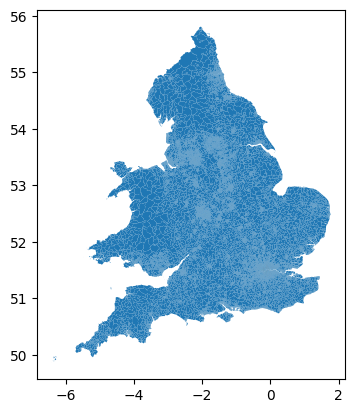

In [3]:
lsoa_gdf.plot()

Download Index of Multiple Deprivation data for 2019.

There's loads of data in here, for example indices on each measure of deprivation, but we're only interested in:
- `Decile`: it's relative measure of deprivation on scale of 1-10, 1 being most deprived & 10 being leasted deprived
- `Indices of Deprivation`: we're specifically interested in the `a. Index of Multiple Deprivation (IMD)` which accounts for all indices.

In [4]:
def download_imd(url: str) -> pd.DataFrame:
    """Quick wrapper for downloading IMD file from a given URL into a pandas DataFrame."""
    great_success = 200
    response = requests.get(url, timeout=20)
    if response.status_code == great_success:
        csv_data = io.StringIO(response.text)
        data = pd.read_csv(csv_data)
        data = data.applymap(lambda x: x.strip() if isinstance(x, str) else x)
        data["DateCode"] = data.DateCode.astype(int)
        data["Value"] = data.Value.astype(int)
        data = data[
            (data["Measurement"] == "Decile")
            & (
                data["Indices of Deprivation"]
                == "a. Index of Multiple Deprivation (IMD)"
            )
        ]
        return data[["FeatureCode", "DateCode", "Value"]]
    print(f"Failed to download the file: {response.status_code}")
    return None


# 2019
imd_df = download_imd(
    url="https://opendatacommunities.org/downloads/cube-table?uri=http%3A%2F%2Fopendatacommunities.org%2Fdata%2Fsocietal-wellbeing%2Fimd2019%2Findices"
)

/var/folders/3v/b8q6sbt52_x7xdvjlh1r21880000gn/T/ipykernel_49272/4104679506.py:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data = data.applymap(lambda x: x.strip() if isinstance(x, str) else x)


In [5]:
imd_gdf = lsoa_gdf.merge(imd_df, left_on="LSOA11CD", right_on="FeatureCode").drop(["FeatureCode"], axis=1)

In [7]:
values = imd_gdf["Value"].to_numpy()
values = np.nan_to_num(values, nan=1)

normalizer = LogNorm(1, values.max(), clip=True)
normalized_values = normalizer(values)

colors = apply_continuous_cmap(normalized_values, colormaps["YlGnBu"])

In [8]:
filter_values = np.column_stack([imd_gdf["Value"]])

initial_filter_range = [1, 10]

filter_extension = DataFilterExtension(filter_size=1)

In [9]:
deprivation_layer = PolygonLayer.from_geopandas(
    gdf=imd_gdf,
    extensions=[filter_extension],
    get_fill_color=colors,
    get_filter_value=filter_values,
    filter_range=initial_filter_range,
    line_width_min_pixels=0
)

In [10]:
map_layout = widgets.Layout(height="1200px")

m = Map(deprivation_layer)

m.basemap_style = (
    "https://basemaps.cartocdn.com/gl/dark-matter-nolabels-gl-style/style.json"
)

m

Map(basemap_style='https://basemaps.cartocdn.com/gl/dark-matter-nolabels-gl-style/style.json', layers=[Polygon…

In [11]:
imd_slider = FloatRangeSlider(
    value=initial_filter_range, min=1, max=10, step=1, description="IMD Decile: "
)
imd_slider

FloatRangeSlider(value=(1.0, 10.0), description='IMD Decile: ', max=10.0, min=1.0, step=1.0)

In [12]:
_ = jsdlink((imd_slider, "value"), (deprivation_layer, "filter_range"))

In [14]:
m.to_html("examples/deprivation.html")